# RNN model with MNIST dataset

## 1. import package

In [1]:
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.utils import shuffle 
import tensorflow as tf

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2. Set hyperparameters

In [2]:
learning_rate = 0.001
batch_size = 128
epochs = 10

## 3. Load data and preprocess

Data shape:  (28, 28)
Label:  5


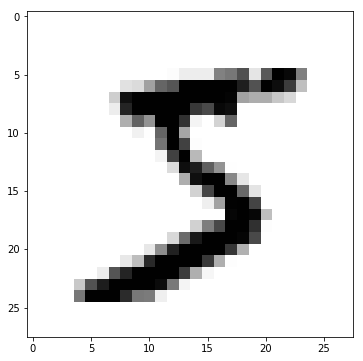

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

print('Data shape: ', X_train[0].shape)
print('Label: ', y_train[0])
plt.figure(figsize=(6, 6))
plt.imshow(X_train[0], cmap='binary')
plt.show()

In [4]:
X_train = X_train / 255.
X_test = X_test / 255.
y_train = np.eye(10)[y_train[:]]
y_test = np.eye(10)[y_test[:]]

In [5]:
def batch_gen(X, y, batch_size):
    X, y = shuffle(X, y)
    batch_index = 0
    
    while batch_index < len(X):
        batch_X = X[batch_index : batch_index+batch_size]
        batch_y = y[batch_index : batch_index+batch_size]
        batch_index += batch_size
        yield batch_X, batch_y

## 4. Build the graph

In [6]:
def RNN_layer(inputs, units):
    BasicRNN_cell = tf.nn.rnn_cell.BasicRNNCell(num_units=units)
    init_state = BasicRNN_cell.zero_state(tf.shape(inputs)[0], dtype=tf.float32) # shape = (batch, units)
#     init_state = tf.zeros([tf.shape(inputs)[0], units])
    outputs, states = tf.nn.dynamic_rnn(BasicRNN_cell, inputs, initial_state=init_state)
    
    return outputs

In [7]:
tf.reset_default_graph()

with tf.name_scope("inputs"):
    input_data = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='input_data')
    y_label = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='label')

with tf.variable_scope("RNN_layer"):
    outputs = RNN_layer(input_data, 32)   

with tf.variable_scope("output_layer"):
    RNN_last_outputs = outputs[:,-1,:]  # outputs shape = (batch, timestep, feature)
    prediction = tf.layers.dense(inputs=RNN_last_outputs, units=10)

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction,labels=y_label))

with tf.name_scope("optimizer"):
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    

init = tf.global_variables_initializer()

In [8]:
outputs

<tf.Tensor 'RNN_layer/rnn/transpose_1:0' shape=(?, 28, 32) dtype=float32>

In [9]:
RNN_last_outputs

<tf.Tensor 'output_layer/strided_slice:0' shape=(?, 32) dtype=float32>

In [10]:
tf.global_variables()

[<tf.Variable 'RNN_layer/rnn/basic_rnn_cell/kernel:0' shape=(60, 32) dtype=float32_ref>,
 <tf.Variable 'RNN_layer/rnn/basic_rnn_cell/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'output_layer/dense/kernel:0' shape=(32, 10) dtype=float32_ref>,
 <tf.Variable 'output_layer/dense/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'optimizer/beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'optimizer/beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'RNN_layer/rnn/basic_rnn_cell/kernel/Adam:0' shape=(60, 32) dtype=float32_ref>,
 <tf.Variable 'RNN_layer/rnn/basic_rnn_cell/kernel/Adam_1:0' shape=(60, 32) dtype=float32_ref>,
 <tf.Variable 'RNN_layer/rnn/basic_rnn_cell/bias/Adam:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'RNN_layer/rnn/basic_rnn_cell/bias/Adam_1:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'output_layer/dense/kernel/Adam:0' shape=(32, 10) dtype=float32_ref>,
 <tf.Variable 'output_layer/dense/kernel/Adam_1:0' shape=(32, 10) dtype=float32_re

In [ ]:
# with tf.keras

tf.reset_default_graph()

with tf.name_scope("inputs"):
    input_data = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='input_data')
    y_label = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='label')

with tf.variable_scope("RNN_layer"):
    rnn_out = tf.keras.layers.SimpleRNN(units=32)(input_data)

with tf.variable_scope("output_layer"):
    prediction = tf.layers.dense(inputs=rnn_out, units=10)

with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction,labels=y_label))

with tf.name_scope("optimizer"):
    opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y_label, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))    

init = tf.global_variables_initializer()

## 5. Train the model

In [11]:
sess = tf.Session()
sess.run(init)

In [12]:
for epoch_index in range(epochs):
    loss_ls, acc_ls = [], []
    get_batch = batch_gen(X_train, y_train, batch_size)
    
    for batch_X, batch_y in get_batch:
        _,  batch_acc, batch_loss = sess.run([opt, accuracy, loss], feed_dict={input_data: batch_X, y_label:batch_y})
        loss_ls.append(batch_loss)
        acc_ls.append(batch_acc)

    print("Epoch ", epoch_index)
    print("Accuracy ", np.mean(acc_ls), "     Loss ", np.mean(loss_ls))
    print("__________________")    

Epoch  0
Accuracy  0.5455812      Loss  1.3097558
__________________
Epoch  1
Accuracy  0.7389837      Loss  0.75747633
__________________
Epoch  2
Accuracy  0.81153935      Loss  0.58429193
__________________
Epoch  3
Accuracy  0.85716504      Loss  0.46653154
__________________
Epoch  4
Accuracy  0.8844283      Loss  0.38438472
__________________
Epoch  5
Accuracy  0.89844304      Loss  0.33981544
__________________
Epoch  6
Accuracy  0.9088708      Loss  0.30613613
__________________
Epoch  7
Accuracy  0.9172941      Loss  0.28063262
__________________
Epoch  8
Accuracy  0.9215363      Loss  0.26711744
__________________
Epoch  9
Accuracy  0.92621714      Loss  0.25154164
__________________


In [13]:
print("Test Accuracy:", sess.run(accuracy, feed_dict={input_data: X_test, y_label: y_test}))        

Test Accuracy: 0.9352


In [14]:
sess.close()

## Practice 1
1. 把RNN cell換成LSTM觀察Accuracy是否會上升? (hint: tf.nn.rnn_cell.BasicLSTMCell)
2. 把RNN cell換成GRU觀察Accuracy是否會上升? (hint: tf.nn.rnn_cell.GRUCell)


## Practice 2
把手寫數字兩張平行輸入到model預測，輸入資料變成time_step = 28, input_data_dimension = 56

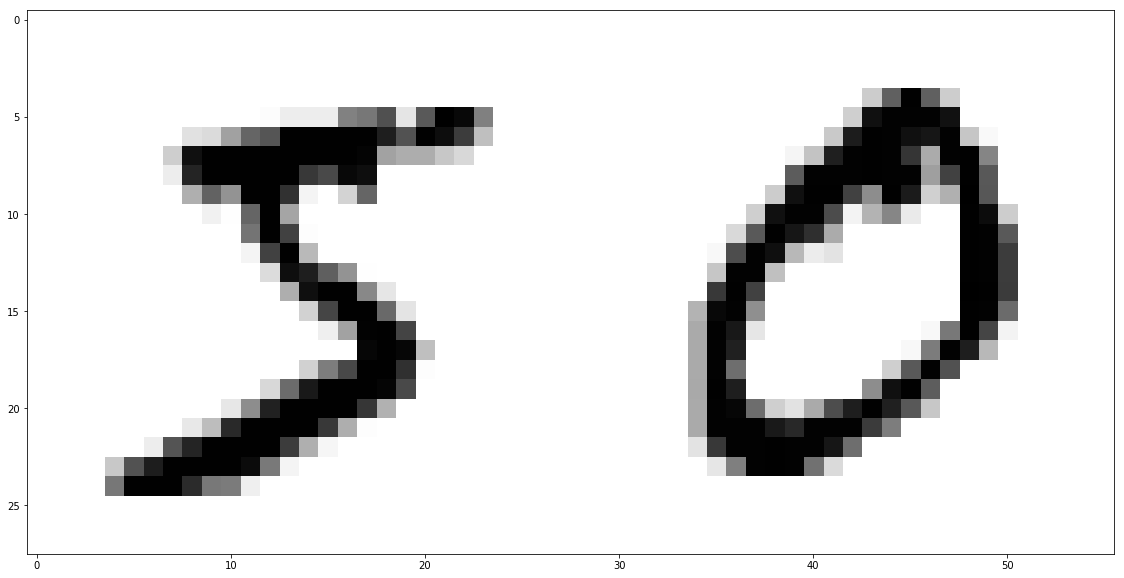

In [15]:
#show training data
plt.figure(figsize=(20,10))
img1 = X_train[0]
img2 = X_train[1]
img = np.concatenate((img1,img2),axis=1)  
plt.imshow(img, cmap='binary')
plt.show()